<a href="https://colab.research.google.com/github/leotimus/WebToEpub/blob/master/Mini_Project_1_Anh_Nguyen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Colab Link: https://colab.research.google.com/drive/1emoftQe9rBB7LKmQb-QR7RI1eNol8xze**

# **Part 1: Preprocessing**

In [0]:
import pandas as pd
dateFormat1 = "%Y-%m-%d"
#Read the data
trips = pd.read_csv('https://github.com/SDS-AAU/M1-2019/raw/master/data/trips.csv')
trips.head()

,Unnamed: 0,username,country,country_code,country_slug,date_end,date_start,latitude,longitude,place,place_slug
0,0,@lewellenmichael,Mexico,MX,mexico,2018-06-15,2018-06-04,21,-101,Guanajuato,mexico
1,1,@lewellenmichael,Mexico,MX,mexico,2018-06-03,2018-05-31,19,-99,Mexico City,mexico-city-mexico
2,2,@lewellenmichael,Mexico,MX,mexico,2017-11-05,2017-11-01,21,-86,Cancun,cancun-mexico
3,3,@lewellenmichael,Jordan,JO,jordan,2017-08-07,2017-07-24,31,35,Amman,amman-jordan
4,4,@waylandchin,China,CN,china,2017-03-18,2017-02-17,40,122,Yingkou,china


a) Trips: transform dates into timestamps

In [0]:
#Convert datatype of date_start and date_end to datetime64[ns]
trips['date_start'] = pd.to_datetime(trips['date_start'], format = dateFormat1, errors = 'coerce')
trips['date_end'] = pd.to_datetime(trips['date_end'], format = dateFormat1, errors = 'coerce')

b) Calculate trip duration in days

In [0]:
#Drop all columns where date_start and date_end are missing
trips.dropna(subset=['date_start', 'date_end'], inplace=True)


# add duration column
print('add duration column')
trips['duration'] = trips['date_end'].subtract(trips['date_start']).dt.days
print('Current size: ' + str(len(trips)))

add duration column
Current size: 46275


c) Filter extreme (fake?) observations for durations as well as dates - start and end

In [0]:
# between 1 and 97
print('filter extreme duration')
quantile_upper = trips['duration'].quantile(0.97)
quantile_lower = trips['duration'].quantile(0.01)
trips = trips[(trips["duration"] > quantile_lower) & (trips["duration"] < quantile_upper)]
print('Current size: ' + str(len(trips)))

filter extreme duration
Current size: 43328


d) join country list data with country code as key

In [0]:
# Read the data
countries = pd.read_csv('https://github.com/SDS-AAU/M1-2019/raw/master/data/countrylist.csv')
trips = trips.join(countries.set_index('alpha_2'), on='country_code')

e) Set DateTime index as the start date of a trip

In [0]:
trips = trips.set_index('date_start')
trips.head()

,Unnamed: 0,username,country,country_code,country_slug,date_end,latitude,longitude,place,place_slug,duration,region,sub_region
date_start,,,,,,,,,,,,,
2018-06-04,0,@lewellenmichael,Mexico,MX,mexico,2018-06-15,21,-101,Guanajuato,mexico,11,Americas,Latin America and the Caribbean
2018-05-31,1,@lewellenmichael,Mexico,MX,mexico,2018-06-03,19,-99,Mexico City,mexico-city-mexico,3,Americas,Latin America and the Caribbean
2017-11-01,2,@lewellenmichael,Mexico,MX,mexico,2017-11-05,21,-86,Cancun,cancun-mexico,4,Americas,Latin America and the Caribbean
2017-07-24,3,@lewellenmichael,Jordan,JO,jordan,2017-08-07,31,35,Amman,amman-jordan,14,Asia,Western Asia
2017-02-17,4,@waylandchin,China,CN,china,2017-03-18,40,122,Yingkou,china,29,Asia,Eastern Asia


# **Part 2: People**

In [0]:
#Read the data
people = pd.read_csv("https://github.com/SDS-AAU/M1-2019/raw/master/data/people.csv", index_col=0)

# Check for missing data 
people.isnull().sum()

username            0
followers           0
following           0
work_raw         2434
education_raw    3565
dtype: int64

In [0]:
#Drop all columns where education_raw and work_raw are missing 
people.dropna(subset=['education_raw'], inplace=True)
people.dropna(subset=['work_raw'], inplace=True)

a) How many people having at least a “High School” diploma?

In [0]:
# Use lambda expression to verify entry with "High School" string 
isWithHighSchoolEdu = lambda x:('High School' in x)

result = people['education_raw'].apply(isWithHighSchoolEdu)
result.head()

0      True
7      True
14    False
15     True
16     True
Name: education_raw, dtype: bool

In [0]:
# The number of people having at least "High School" diploma is "True" in "result" 
numOfHS = len(result[result == True].index)
print("Number of people having at least a “High School” diploma:", numOfHS)

Number of people having at least a “High School” diploma: 126


b) How many people working with “Software Dev” have a Master's Degree?

In [0]:
# The same technique with the question above
master = "Master's Degree"
softwareDevsHaveMasterDegree = lambda x : (('Software Dev' in x['work_raw']) & (master in x['education_raw']))
softwareDevsHaveMasterDegree = people.apply(softwareDevsHaveMasterDegree, axis=1)

print("Number of people working with Software Dev have a Master's Degree: " + str(len(softwareDevsHaveMasterDegree[softwareDevsHaveMasterDegree == True].index)))


Number of people working with Software Dev have a Master's Degree: 57


c) Who is the person with a Master's Degree that has the highest number of followers?

In [0]:
master = "Master's Degree"

#Filter people with Master's Degree, use str.contains and search the key word in "education_raw"
masters = people[['username', 'followers', 'education_raw']][(people.education_raw.str.contains(master))]

#Find the person having the most followers
topFollower = masters[['username', "followers"]][(masters.followers == masters.followers.max())]
print('That person is ' + topFollower.username + ' who has ' + str(topFollower.followers) + ' followers.')

2043    That person is @levelsio who has 2043    2182\...
Name: username, dtype: object


# **Part 3: Trips**

In [0]:
# Have a look at the data
trips.head(5)

,Unnamed: 0,username,country,country_code,country_slug,date_end,latitude,longitude,place,place_slug,duration,region,sub_region
date_start,,,,,,,,,,,,,
2018-06-04,0,@lewellenmichael,Mexico,MX,mexico,2018-06-15,21,-101,Guanajuato,mexico,11,Americas,Latin America and the Caribbean
2018-05-31,1,@lewellenmichael,Mexico,MX,mexico,2018-06-03,19,-99,Mexico City,mexico-city-mexico,3,Americas,Latin America and the Caribbean
2017-11-01,2,@lewellenmichael,Mexico,MX,mexico,2017-11-05,21,-86,Cancun,cancun-mexico,4,Americas,Latin America and the Caribbean
2017-07-24,3,@lewellenmichael,Jordan,JO,jordan,2017-08-07,31,35,Amman,amman-jordan,14,Asia,Western Asia
2017-02-17,4,@waylandchin,China,CN,china,2017-03-18,40,122,Yingkou,china,29,Asia,Eastern Asia


a) Which country received the highest number of trips?

In [0]:
#base on country_slug, count the most frequency country 
country = trips['country_slug'].value_counts().idxmax()
print(country + ' received the highest number of trips.')

united-states received the highest number of trips.


b) Which country received the highest number of trips in 2017?

In [0]:
tripsIn2017 = trips['country_slug'][trips.index.year == 2017]
country = tripsIn2017.value_counts().idxmax()
print(country + ' received the highest number of trips in 2017.')

united-states received the highest number of trips in 2017.


c) Which is the country in 'Eastern Asia' where travellers spent on average least time when going there?

In [0]:
# From subset "Eastern Asia", groupby "country" criteria, then calculate mean of duration
tripsToEA = trips.query("sub_region == 'Eastern Asia'").groupby(["country"])["duration"].mean().reset_index(name="avg_duration")
print(tripsToEA['country'][tripsToEA.avg_duration == tripsToEA.avg_duration.min()])


4    North Korea
Name: country, dtype: object


Text(0, 0.5, 'Avg Duration')

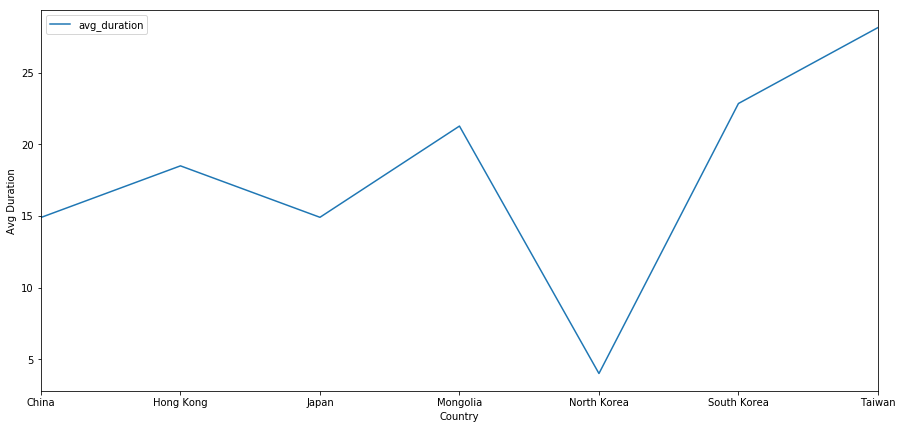

In [0]:
# Visualization
fig, ax1 = plt.subplots(figsize=(15,7))
tripsToEA.plot(x = 'country', y = 'avg_duration', ax=ax1)
ax1.set_xlabel('Country')
ax1.set_ylabel('Avg Duration')

d) Do nomads that indicate working in “Software Dev” tend to have shorter or longer trips on average?

In [0]:
#merge data from 2 dataframe (trips and people) when username is the same 
peopleSubset = trips.join(people.set_index('username'), on='username')
durationByWork = peopleSubset[['username', 'duration', 'work_raw']]
durationByWork.head()

,username,duration,work_raw
date_start,,,
2018-06-04,@lewellenmichael,11,"Software Dev, Startup Founder, Finance, Crypto..."
2018-05-31,@lewellenmichael,3,"Software Dev, Startup Founder, Finance, Crypto..."
2017-11-01,@lewellenmichael,4,"Software Dev, Startup Founder, Finance, Crypto..."
2017-07-24,@lewellenmichael,14,"Software Dev, Startup Founder, Finance, Crypto..."
2017-02-17,@waylandchin,29,NaN


In [0]:
# Calculate mean of trip duration where "Software Dev" appears in "work_raw" and exclude NaN 
softwareDevAverageDuration = (durationByWork[durationByWork.work_raw.str.contains('Software Dev', na=False)])['duration'].mean()

# Calculate mean of trip duration of people other than Software Dev and those with NaN (in work_raw)
otherAverageDuration = (durationByWork[~durationByWork.work_raw.str.contains('Software Dev', na=True)])['duration'].mean()

print('On average Software developer has trip duration: ' + str(softwareDevAverageDuration))
print('On average others have trip duration: ' + str(otherAverageDuration))


On average Software developer has trip duration: 16.300127172530733
On average others have trip duration: 17.369210977701545


So the answer is "Software Dev” tend to have shorter trips on average

e) Visualize over-time median trip duration overall (bonus: and split by world-region).

Text(0, 0.5, 'Number of Trips')

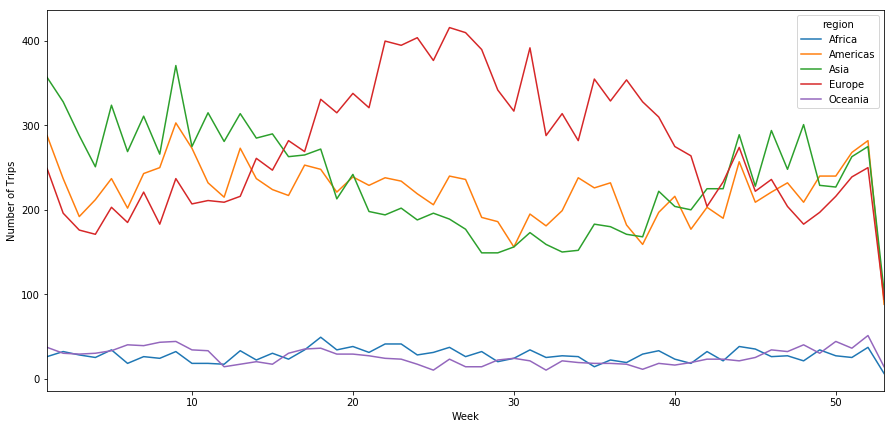

In [0]:
import matplotlib.pyplot as plt

trips['week'] = trips.index.week

fig, ax = plt.subplots(figsize=(15,7))

trips.groupby(['week','region'])["duration"].count().unstack().plot(ax=ax)

ax.set_xlabel('Week')
ax.set_ylabel('Number of Trips')